In [78]:
import os
import warnings
from datetime import datetime

import cartopy.crs as ccrs
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import folium
import geopandas as gpd
import georaster
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymodis
import rasterio
import rioxarray as rxr
import xarray as xr
from folium import plugins
from matplotlib.colors import Normalize
from meteostat import Daily, Point
from mpl_toolkits.basemap import Basemap
from rasterio.warp import Resampling, reproject
from sentinelsat import SentinelAPI, geojson_to_wkt, read_geojson
from shapely.geometry import box, mapping

# MODIS DATA

In [79]:
tiff_file = rxr.open_rasterio("MOD14A1.A2021209.h10v03.061.2021218013045.hdf")

In [80]:
tiff_file

<xarray.Dataset> Size: 92MB
Dimensions:      (band: 8, x: 1200, y: 1200)
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 10kB -8.895e+06 -8.894e+06 ... -7.784e+06
  * y            (y) float64 10kB 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref  int64 8B 0
Data variables:
    FireMask     (band, y, x) uint8 12MB ...
    QA           (band, y, x) uint8 12MB ...
    MaxFRP       (band, y, x) int32 46MB ...
    sample       (band, y, x) uint16 23MB ...
Attributes: (12/84)
    ALGORITHMPACKAGEACCEPTANCEDATE:     04-2006
    ALGORITHMPACKAGEMATURITYCODE:       Normal
    ALGORITHMPACKAGENAME:               MOD_PR14A
    ALGORITHMPACKAGEVERSION:            5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ...                                 ...
    TileID:                             51010003
    UnknownPix:                         0, 0, 0, 0, 1, 14, 2, 5
    VERSIONID:                          61
    VERTICALTILENUMBER:                 3
    VerticalTileNumber:                 3
    WESTBOUNDINGCOORDINATE:             -159.99999995957

In [81]:
# put the dates from the attributes in an array
dates = tiff_file.attrs["DAYSOFYEAR"]

In [82]:
print(dates)

2021-07-28, 2021-07-29, 2021-07-30, 2021-07-31, 2021-08-01, 2021-08-02, 2021-08-03, 2021-08-04


In [83]:
dates = dates.split(", ")

In [84]:
date_objects = [datetime.strptime(date_str, "%Y-%m-%d") for date_str in dates]

print(date_objects)

[datetime.datetime(2021, 7, 28, 0, 0), datetime.datetime(2021, 7, 29, 0, 0), datetime.datetime(2021, 7, 30, 0, 0), datetime.datetime(2021, 7, 31, 0, 0), datetime.datetime(2021, 8, 1, 0, 0), datetime.datetime(2021, 8, 2, 0, 0), datetime.datetime(2021, 8, 3, 0, 0), datetime.datetime(2021, 8, 4, 0, 0)]


In [85]:
tiff_file.FireMask

<xarray.DataArray 'FireMask' (band: 8, y: 1200, x: 1200)> Size: 12MB
[11520000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 64B 1 2 3 4 5 6 7 8
  * x            (x) float64 10kB -8.895e+06 -8.894e+06 ... -7.784e+06
  * y            (y) float64 10kB 6.671e+06 6.67e+06 ... 5.561e+06 5.56e+06
    spatial_ref  int64 8B 0
Attributes:
    legend:        Classes:\n0 missing input data\n1 not processed (obsolete)...
    valid_range:   0, 9
    _FillValue:    0
    scale_factor:  1.0
    add_offset:    0.0

In [86]:
tiff_file = tiff_file.rio.reproject("EPSG:4326")

In [87]:
tiff_file.FireMask.rio.write_nodata(0, inplace=True)

tiff_file = tiff_file.FireMask.rio.reproject("EPSG:4326")

# print(modis_pre.rio.crs)


# Crete if doesn't exist a folder to save the data
if not os.path.exists("data"):
    os.makedirs("data")

tiff_file.rio.to_raster("data/fire.tif")

In [88]:
# Open the raster file
fire = rasterio.open("data/fire.tif")

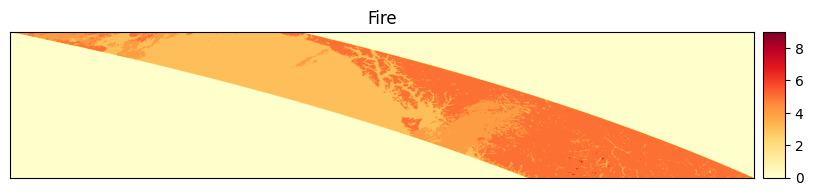

<Axes: title={'center': 'Fire'}>

In [89]:
ep.plot_bands(fire.read(1), title="Fire", cmap="YlOrRd", figsize=(10, 10))

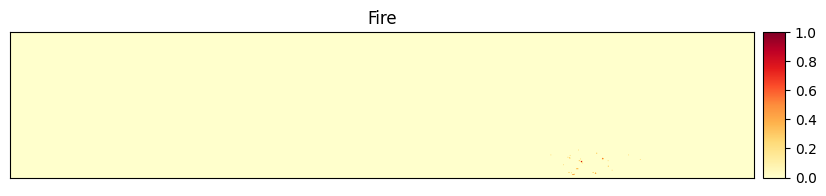

<Axes: title={'center': 'Fire'}>

In [90]:
ep.plot_bands(fire.read(1) > 6, title="Fire", cmap="YlOrRd", figsize=(10, 10))

In [91]:
def get_coords_and_pixels(dataset):
    coords = []
    pixels = []

    for i in range(0, dataset.read(1).shape[0]):
        for j in range(0, dataset.read(1).shape[1]):
            if dataset.read(1)[i, j] > 6:
                # Printing the coordinates of the pixel =9
                print("Fire Pixel at: ", dataset.xy(i, j))
                # Store the coordinates of the pixel =9
                coords.append(dataset.xy(i, j))
                pixels.append([i, j])

    return coords, pixels

In [92]:
coords, pixels = get_coords_and_pixels(fire)

Fire Pixel at:  (-120.95749637234849, 51.91536369187604)
Fire Pixel at:  (-119.730227104381, 51.70059156998173)
Fire Pixel at:  (-119.69954537268181, 51.70059156998173)
Fire Pixel at:  (-122.85976373769807, 51.57786464318498)
Fire Pixel at:  (-117.52114242203953, 51.57786464318498)
Fire Pixel at:  (-121.54044927463303, 51.5471829114858)
Fire Pixel at:  (-121.69385793312897, 51.42445598468905)
Fire Pixel at:  (-121.60181273803141, 51.39377425298986)
Fire Pixel at:  (-121.57113100633222, 51.363092521290675)
Fire Pixel at:  (-121.54044927463303, 51.363092521290675)
Fire Pixel at:  (-119.30068286059239, 51.363092521290675)
Fire Pixel at:  (-119.30068286059239, 51.332410789591485)
Fire Pixel at:  (-119.2700011288932, 51.332410789591485)
Fire Pixel at:  (-120.83476944555173, 51.3017290578923)
Fire Pixel at:  (-119.33136459229158, 51.3017290578923)
Fire Pixel at:  (-119.30068286059239, 51.3017290578923)
Fire Pixel at:  (-119.2700011288932, 51.3017290578923)
Fire Pixel at:  (-116.7234173978606

In [93]:
coords

[(-120.95749637234849, 51.91536369187604),
 (-119.730227104381, 51.70059156998173),
 (-119.69954537268181, 51.70059156998173),
 (-122.85976373769807, 51.57786464318498),
 (-117.52114242203953, 51.57786464318498),
 (-121.54044927463303, 51.5471829114858),
 (-121.69385793312897, 51.42445598468905),
 (-121.60181273803141, 51.39377425298986),
 (-121.57113100633222, 51.363092521290675),
 (-121.54044927463303, 51.363092521290675),
 (-119.30068286059239, 51.363092521290675),
 (-119.30068286059239, 51.332410789591485),
 (-119.2700011288932, 51.332410789591485),
 (-120.83476944555173, 51.3017290578923),
 (-119.33136459229158, 51.3017290578923),
 (-119.30068286059239, 51.3017290578923),
 (-119.2700011288932, 51.3017290578923),
 (-116.72341739786067, 51.27104732619311),
 (-120.9268146406493, 51.17900213109555),
 (-120.89613290895011, 51.17900213109555),
 (-118.93250208020214, 51.17900213109555),
 (-120.80408771385254, 51.14832039939637),
 (-120.77340598215335, 51.14832039939637),
 (-120.742724250

In [94]:
# create a bounding box using the coords of the fire
min_lat = min([coord[0] for coord in coords])
max_lat = max([coord[0] for coord in coords])
min_lon = min([coord[1] for coord in coords])
max_lon = max([coord[1] for coord in coords])

bbox_coords = (min_lat, min_lon, max_lat, max_lon)

# add padding to the bounding box
padding = 1.6

bbox_coords = (
    min_lat - padding,
    min_lon - padding,
    max_lat + padding,
    max_lon + padding,
)

In [95]:
bbox_coords

(-124.45976373769807,
 48.62786844842075,
 -115.12341739786068,
 53.51536369187604)

In [96]:
output_dir = "data"

# Open the MODIS image
with rasterio.open("data/fire.tif") as src:
    # Get the window corresponding to the bounding box
    minx, miny, maxx, maxy = bbox_coords
    window = src.window(minx, miny, maxx, maxy)

    # Read the data from the window
    modis_data = src.read(window=window)

    # Get the profile of the cropped data
    profile = src.profile.copy()
    profile.update(
        {
            "height": window.height,
            "width": window.width,
            "transform": src.window_transform(window),
        }
    )

    # Define output path for the cropped MODIS image
    modis_clipped_path = os.path.join(output_dir, "clipped_modis.tif")

    # Write the cropped MODIS data to a new GeoTIFF file
    with rasterio.open(modis_clipped_path, "w", **profile) as dst:
        dst.write(modis_data)

print("Cropped MODIS image saved successfully at:", modis_clipped_path)

Cropped MODIS image saved successfully at: data/clipped_modis.tif


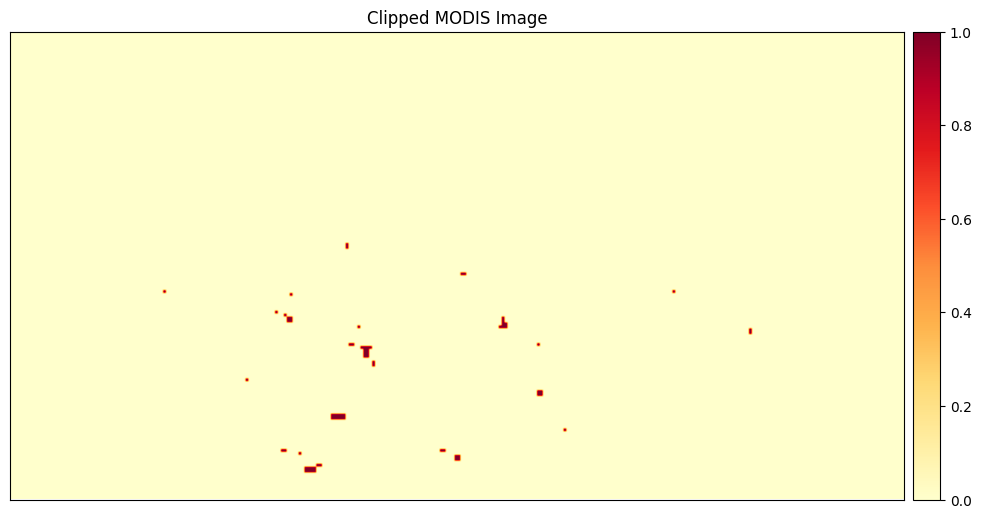

<Axes: title={'center': 'Clipped MODIS Image'}>

In [97]:
# open the clipped MODIS image
clipped_modis = rasterio.open(modis_clipped_path)

# Plot the clipped MODIS image
ep.plot_bands(clipped_modis.read(1) > 6, title="Clipped MODIS Image", cmap="YlOrRd")

In [98]:
new_width = int(128)
new_height = int(128)

# resize the image
clipped_modis_resized = clipped_modis.read(
    out_shape=(clipped_modis.count, new_height, new_width),
    resampling=Resampling.bilinear,
)

# Save
# Define output path for the resized MODIS image
modis_resized_path = os.path.join(output_dir, "resized_modis.tif")

# Update the profile of the resized MODIS image

profile.update(
    {
        "height": new_height,
        "width": new_width,
        "transform": clipped_modis.transform,
    }
)

# Write the resized MODIS data to a new GeoTIFF file
with rasterio.open(modis_resized_path, "w", **profile) as dst:
    dst.write(clipped_modis_resized)

In [99]:
# Open the resized MODIS image

tiff_file = rxr.open_rasterio(modis_resized_path)

tiff_file.shape

(8, 128, 128)

# WEATHER DATA

In [104]:
tiff_file = rxr.open_rasterio(modis_resized_path)

In [107]:
tiff_file.shape

(8, 128, 128)

In [108]:
mask_tavg = np.zeros_like(tiff_file, dtype=float)
mask_wdir = np.zeros_like(tiff_file, dtype=float)
mask_prcp = np.zeros_like(tiff_file, dtype=float)
mask_wspd = np.zeros_like(tiff_file, dtype=float)

In [110]:
tiff_file = rasterio.open(modis_resized_path)

In [115]:
from datetime import timedelta
import tqdm

# hide warnings
warnings.filterwarnings("ignore")

for k in range(0, len(date_objects)):
    print("Processing data for date: ", date_objects[k])
    # iterate over every pixel in the band 1 image
    for i in tqdm.tqdm(range(tiff_file.read(k + 1).shape[0])):
        for j in range(tiff_file.read(k + 1).shape[1]):
            # print(tiff_file.xy(i, j))

            point = Point(j, i)
            # Get daily data
            data = Daily(point, date_objects[0], date_objects[0])
            data = data.normalize()
            data = data.interpolate()
            data = data.fetch() 
            # # If data is not empty, assign values to the mask arrays
            if not data.empty:
                # print(data["tavg"])
                mask_tavg[k, i, j] = data["tavg"]
                mask_prcp[k, i, j] = data["prcp"]
                mask_wdir[k, i, j] = data["wdir"]
                mask_wspd[k, i, j] = data["wspd"]

            if data.empty:
                mask_tavg[k, i, j] = np.nan
                mask_prcp[k, i, j] = np.nan
                mask_wdir[k, i, j] = np.nan
                mask_wspd[k, i, j] = np.nan

Processing data for date:  2021-07-28 00:00:00


100%|██████████| 128/128 [04:37<00:00,  2.17s/it]


Processing data for date:  2021-07-29 00:00:00


100%|██████████| 128/128 [04:40<00:00,  2.19s/it]


Processing data for date:  2021-07-30 00:00:00


100%|██████████| 128/128 [04:43<00:00,  2.21s/it]


Processing data for date:  2021-07-31 00:00:00


100%|██████████| 128/128 [04:51<00:00,  2.27s/it]


Processing data for date:  2021-08-01 00:00:00


100%|██████████| 128/128 [04:56<00:00,  2.32s/it]


Processing data for date:  2021-08-02 00:00:00


100%|██████████| 128/128 [04:43<00:00,  2.22s/it]


Processing data for date:  2021-08-03 00:00:00


100%|██████████| 128/128 [04:40<00:00,  2.19s/it]


Processing data for date:  2021-08-04 00:00:00


100%|██████████| 128/128 [04:38<00:00,  2.18s/it]


Number of pixels with no data:  116408
Number of pixels with no data:  118096
Number of pixels with no data:  116584
Number of pixels with no data:  116576


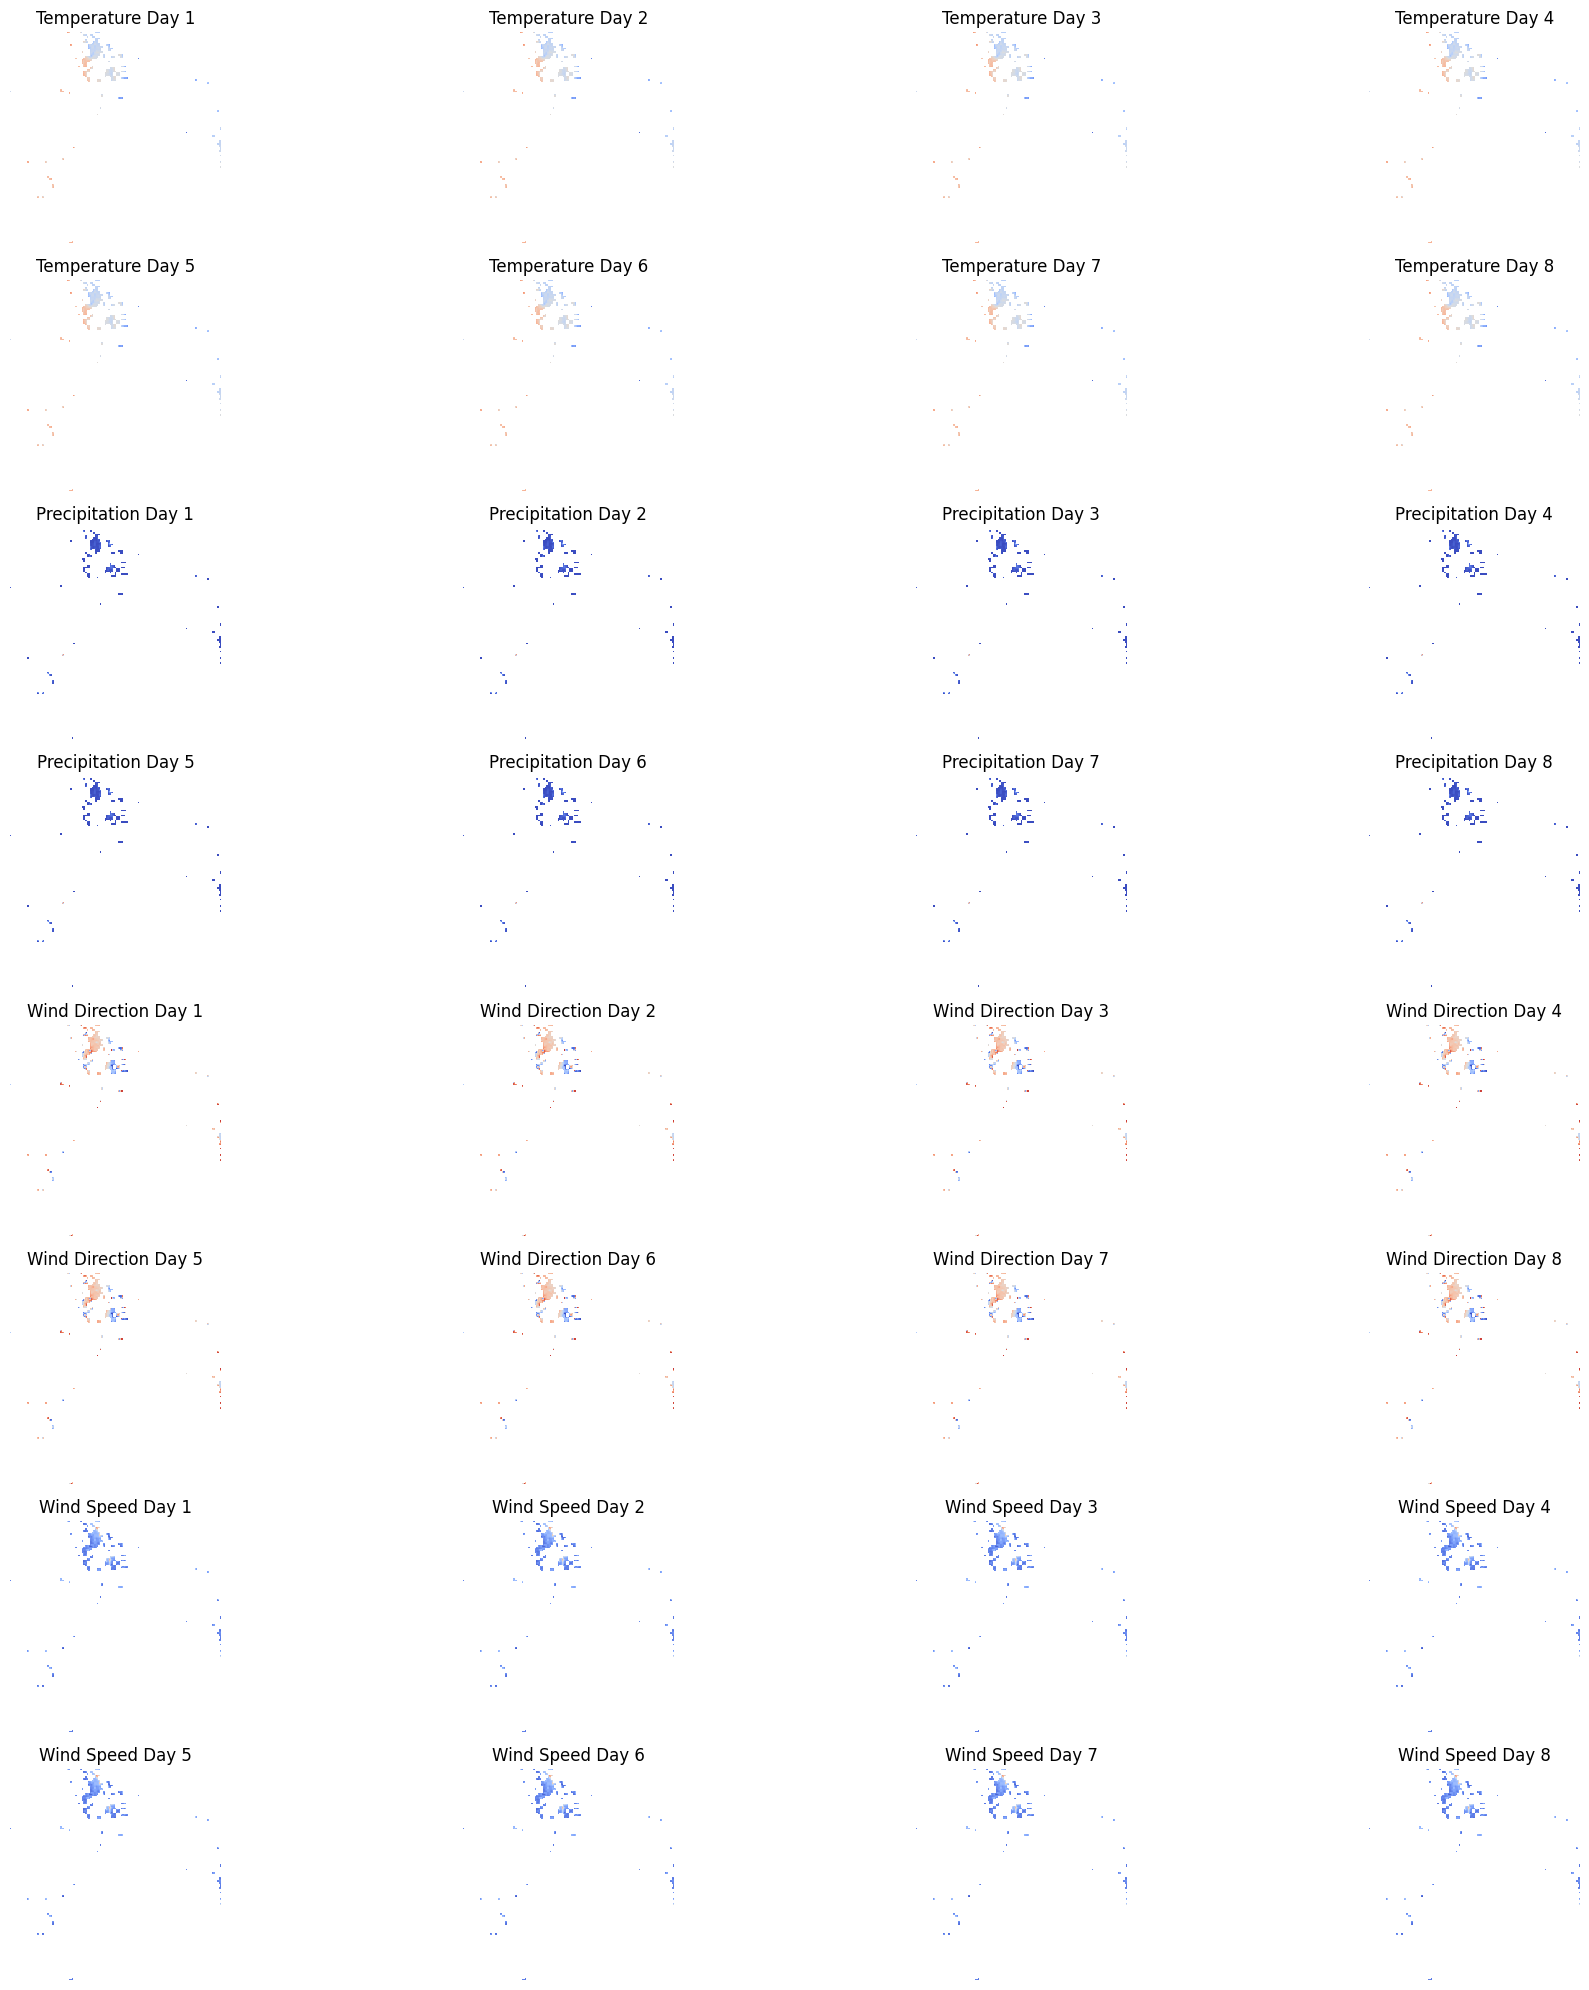

In [121]:
# count the number of pixels with no data
print("Number of pixels with no data: ", np.isnan(mask_tavg).sum())
print("Number of pixels with no data: ", np.isnan(mask_prcp).sum())
print("Number of pixels with no data: ", np.isnan(mask_wdir).sum())
print("Number of pixels with no data: ", np.isnan(mask_wspd).sum())

# plot the data
fig, axs = plt.subplots(8, 4, figsize=(20, 20))
axs = axs.ravel()

# plot the 8 days of data for each variable
for i in range(0, 8):
    axs[i].imshow(mask_tavg[i], cmap="coolwarm")
    axs[i].set_title("Temperature Day {}".format(i + 1))
    axs[i].axis("off")

    axs[i + 8].imshow(mask_prcp[i], cmap="coolwarm")
    axs[i + 8].set_title("Precipitation Day {}".format(i + 1))
    axs[i + 8].axis("off")

    axs[i + 16].imshow(mask_wdir[i], cmap="coolwarm")
    axs[i + 16].set_title("Wind Direction Day {}".format(i + 1))
    axs[i + 16].axis("off")

    axs[i + 24].imshow(mask_wspd[i], cmap="coolwarm")
    axs[i + 24].set_title("Wind Speed Day {}".format(i + 1))
    axs[i + 24].axis("off")

plt.tight_layout()
plt.show()

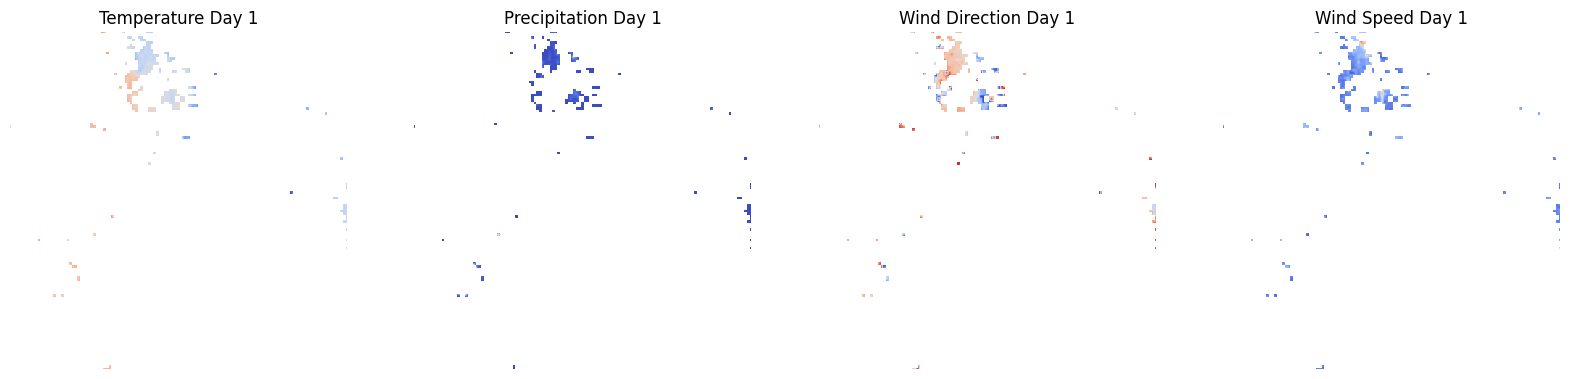

In [123]:
# Just on the first day
fig, axs = plt.subplots(1, 4, figsize=(20, 20))

axs[0].imshow(mask_tavg[0], cmap="coolwarm")
axs[0].set_title("Temperature Day 1")
axs[0].axis("off")

axs[1].imshow(mask_prcp[0], cmap="coolwarm")
axs[1].set_title("Precipitation Day 1")
axs[1].axis("off")

axs[2].imshow(mask_wdir[0], cmap="coolwarm")
axs[2].set_title("Wind Direction Day 1")
axs[2].axis("off")

axs[3].imshow(mask_wspd[0], cmap="coolwarm")
axs[3].set_title("Wind Speed Day 1")
axs[3].axis("off")

plt.show()

In [124]:
profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 128, 'height': 128, 'count': 8, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.03068173169918701, 0.0, -124.45976373769807,
       0.0, -0.030681731699187018, 53.51536369187604), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

In [125]:
mask_prcp.shape

(8, 128, 128)

In [126]:
# Define output path for the resized MODIS image
tavg_path = os.path.join(output_dir, "tavg.tif")
prcp_path = os.path.join(output_dir, "prcp.tif")
wdir_path = os.path.join(output_dir, "wdir.tif")
wspd_path = os.path.join(output_dir, "wspd.tif")

In [127]:
# Update the profile of the resized MODIS image as one band
profile2 = profile.copy()
profile2.update(
    {
        "dtype": "float64",
    }
)
# Write the resized MODIS data to a new GeoTIFF file
with rasterio.open(tavg_path, "w", **profile2) as dst:
    dst.write(mask_tavg)

with rasterio.open(prcp_path, "w", **profile2) as dst:
    dst.write(mask_prcp)

with rasterio.open(wdir_path, "w", **profile2) as dst:
    dst.write(mask_wdir)

with rasterio.open(wspd_path, "w", **profile2) as dst:
    dst.write(mask_wspd)

print("Data saved successfully")

Data saved successfully


Temperature:  (8, 128, 128)
Precipitation:  (8, 128, 128)
Wind Direction:  (8, 128, 128)
Wind Speed:  (8, 128, 128)


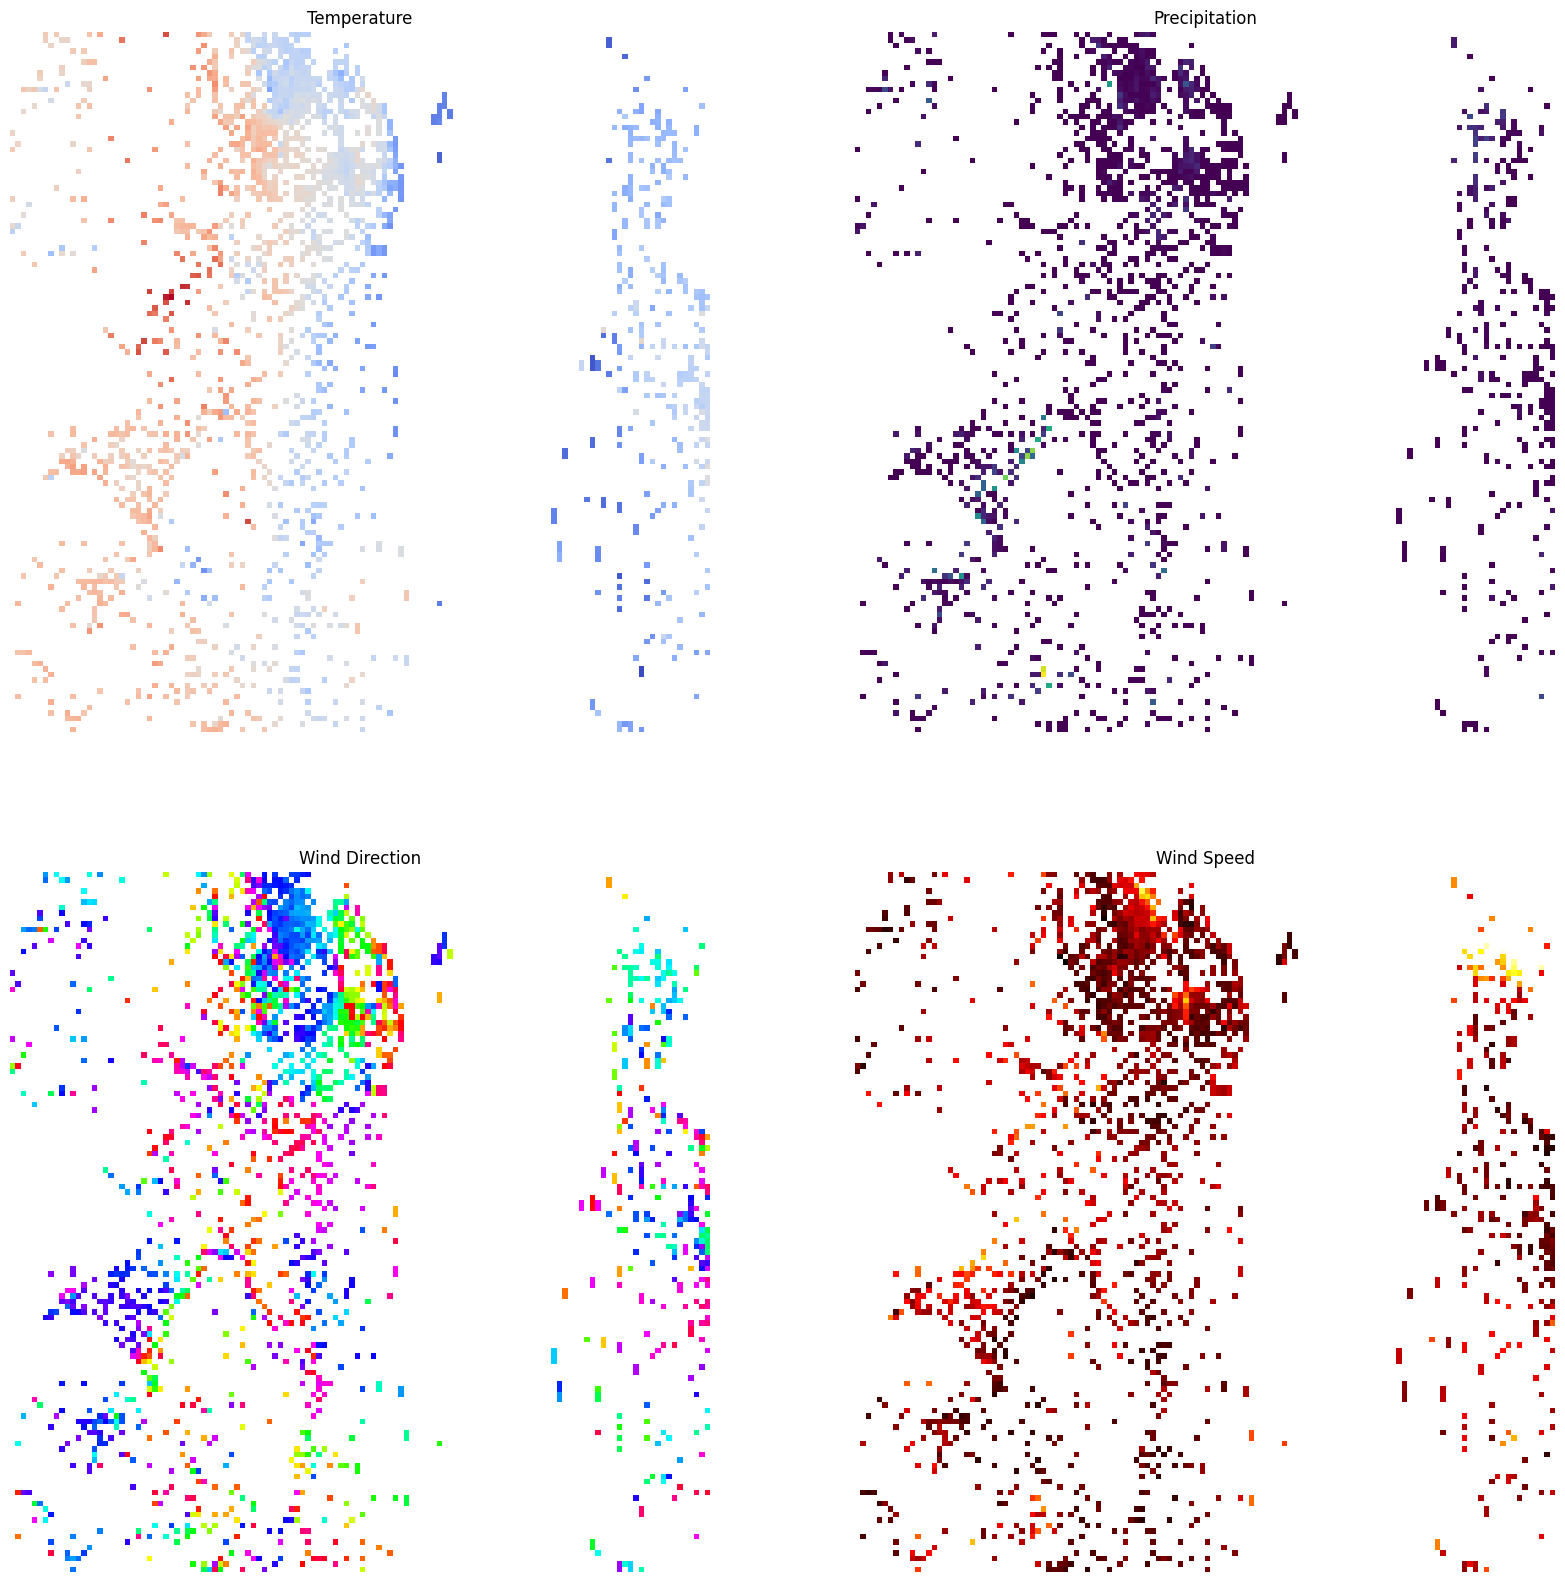

In [131]:
# Open the raster files
tavg_tiff = rxr.open_rasterio(tavg_path)
prcp_tiff = rxr.open_rasterio(prcp_path)
wdir_tiff = rxr.open_rasterio(wdir_path)
wspd_tiff = rxr.open_rasterio(wspd_path)


print("Temperature: ", tavg_tiff.shape)
print("Precipitation: ", prcp_tiff.shape)
print("Wind Direction: ", wdir_tiff.shape)
print("Wind Speed: ", wspd_tiff.shape)


# Open the raster files
tavg_tiff = rasterio.open(tavg_path)
prcp_tiff = rasterio.open(prcp_path)
wdir_tiff = rasterio.open(wdir_path)
wspd_tiff = rasterio.open(wspd_path)


# Plot the data
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.ravel()

# Plot the temperature
axs[0].imshow(tavg_tiff.read(1), cmap="coolwarm")
axs[0].set_title("Temperature")
axs[0].axis("off")

# Plot the precipitation
axs[1].imshow(prcp_tiff.read(1))
axs[1].set_title("Precipitation")
axs[1].axis("off")

axs[2].imshow(wdir_tiff.read(1), cmap="hsv")
axs[2].set_title("Wind Direction")
axs[2].axis("off")

axs[3].imshow(wspd_tiff.read(1), cmap="hot")
axs[3].set_title("Wind Speed")
axs[3].axis("off")

plt.show()

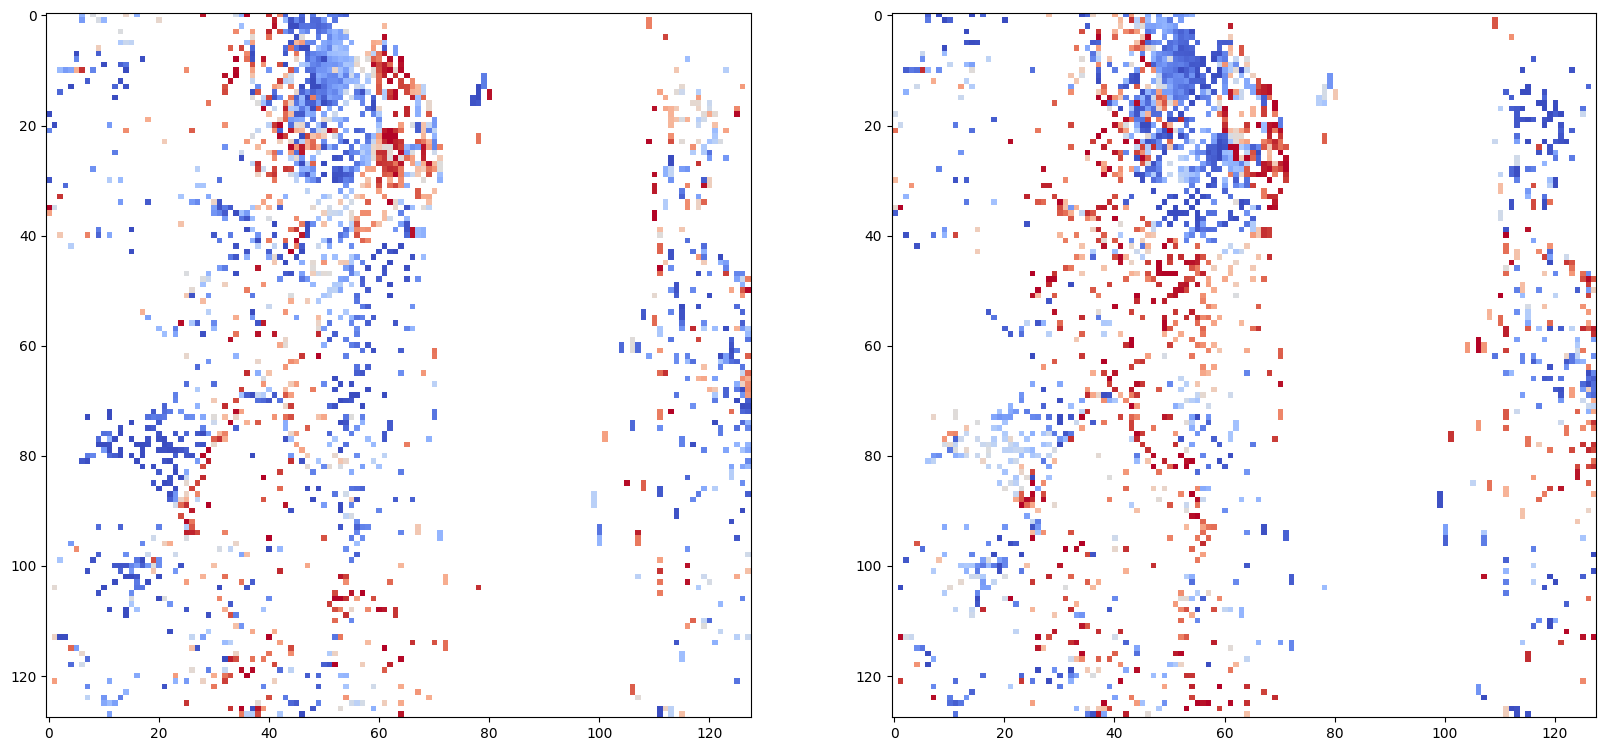

In [134]:
# Use circular encoding for wind direction
def circular_encoding(data):
    data = np.radians(data)
    return np.sin(data), np.cos(data)


# Apply circular encoding to the wind direction for the 8 days
sin_wdir = np.zeros_like(mask_wdir, dtype=float)
cos_wdir = np.zeros_like(mask_wdir, dtype=float)

for i in range(0, 8):
    sin_wdir[i], cos_wdir[i] = circular_encoding(mask_wdir[i])


# Plot the circular encoding
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the sin of the wind direction
axs[0].imshow(sin_wdir[0], cmap="coolwarm")

# Plot the cos of the wind direction
axs[1].imshow(cos_wdir[0], cmap="coolwarm")

plt.show()

# Save
# Define output path for the resized MODIS image

sin_wdir_path = os.path.join(output_dir, "sin_wdir.tif")

cos_wdir_path = os.path.join(output_dir, "cos_wdir.tif")

# Update the profile of the resized MODIS image
profile2 = profile.copy()
profile2.update(
    {
        "dtype": "float64",
    }
)

# Write the resized MODIS data to a new GeoTIFF file
with rasterio.open(sin_wdir_path, "w", **profile2) as dst:
    dst.write(sin_wdir)

with rasterio.open(cos_wdir_path, "w", **profile2) as dst:
    dst.write(cos_wdir)

In [366]:
# Open the raster files
sin_wdir_tiff = rxr.open_rasterio(sin_wdir_path)

cos_wdir_tiff = rxr.open_rasterio(cos_wdir_path)

tavg_tiff = rxr.open_rasterio(tavg_path)
prcp_tiff = rxr.open_rasterio(prcp_path)
wdir_tiff = rxr.open_rasterio(wdir_path)
wspd_tiff = rxr.open_rasterio(wspd_path)

In [367]:
fire_tiff = rxr.open_rasterio(modis_resized_path)

# only keep data > 6
fire_tiff = fire_tiff.where(fire_tiff > 6)

# Save the fire data
fire_path2 = os.path.join(output_dir, "fire2.tif")

fire_tiff.rio.to_raster(fire_path2)

fire_tiff = rasterio.open(fire_path2)

# Data model

In [385]:
# put all my data in a 3d array

X = np.stack(
    [
        tavg_tiff,
        prcp_tiff,
        sin_wdir_tiff,
        cos_wdir_tiff,
        wspd_tiff,
    ],
    axis=0,
)

X.shape

(5, 8, 128, 128)

In [386]:
# Expand the dim of the modis data
X = np.expand_dims(X, axis=0)

X.shape

(1, 5, 8, 128, 128)

In [387]:
# Reshape in (n_sample, n_days, n_features, height, width)
X = np.moveaxis(X, 1, 4)
X.shape

(1, 8, 128, 128, 5)

In [388]:
Y = rxr.open_rasterio(fire_path2)

Y.shape


# Expand the dim of the modis data

Y = np.expand_dims(Y, axis=0)
Y = np.expand_dims(Y, axis=0)

In [389]:
Y.shape

(1, 1, 8, 128, 128)

In [390]:
# Reshape in (n_sample, n_days, n_features, height, width)
Y = np.moveaxis(Y, 1, 4)
Y.shape

(1, 8, 128, 128, 1)

# Model Time

In [391]:
import tensorflow as tf
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    ConvLSTM2D,
    TimeDistributed,
)
from tensorflow.keras.models import Sequential

# Define the ConvLSTM model
model = Sequential(
    [
        # Convolutional LSTM layer with 32 filters, kernel size of (3, 3), and 'same' padding
        ConvLSTM2D(
            filters=32,
            kernel_size=(3, 3),
            padding="same",
            return_sequences=True,
            input_shape=(4, 128, 128, 5),
        ),
        BatchNormalization(),  # Batch normalization layer for normalization
        # Another Convolutional LSTM layer with 64 filters
        ConvLSTM2D(
            filters=64, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        BatchNormalization(),
        # Convolutional layer with 1 filter and kernel size of (3, 3)
        TimeDistributed(
            Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")
        ),
    ]
)

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy")

# Print model summary
model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_56 (ConvLSTM2D)     │ (None, 4, 128, 128,    │        42,752 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 4, 128, 128,    │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_57 (ConvLSTM2D)     │ (None, 4, 128, 128,    │       221,440 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 4, 128, 128,    │           256 │
│ (BatchNormalization)            │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 4, 128, 128, 1) │           577 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,153 (1.01 MB)

 Trainable params: 264,961 (1.01 MB)

 Non-trainable params: 192 (768.00 B)

In [392]:
print(X.shape)
print(Y.shape)

(1, 8, 128, 128, 5)
(1, 8, 128, 128, 1)


In [395]:
# Split the data into training and testing sets for the days, put 4 days for training and 4 days for testing
X_train, X_test = X[:, :4], X[:, 4:]

Y_train, Y_test = Y[:, :4], Y[:, 4:]

In [396]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1, 4, 128, 128, 5),
 (1, 4, 128, 128, 5),
 (1, 4, 128, 128, 1),
 (1, 4, 128, 128, 1))

In [397]:
# Train the model

model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: nan - val_loss: nan
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - loss: nan - val_loss: nan
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step - loss: nan - val_loss: nan
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step - loss: nan - val_loss: nan
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - loss: nan - val_loss: nan
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step - loss: nan - val_loss: nan
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step - loss: nan - val_loss: nan
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step - loss: nan - val_loss: nan
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step - loss: nan - val_loss: nan
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step - loss: nan - val_loss: nan
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step - loss: nan - val_loss: nan
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step - loss: nan - val_loss: nan
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step - loss: nan -

In [398]:
predictions = model.predict(X_test)

predictions.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


(1, 4, 128, 128, 1)

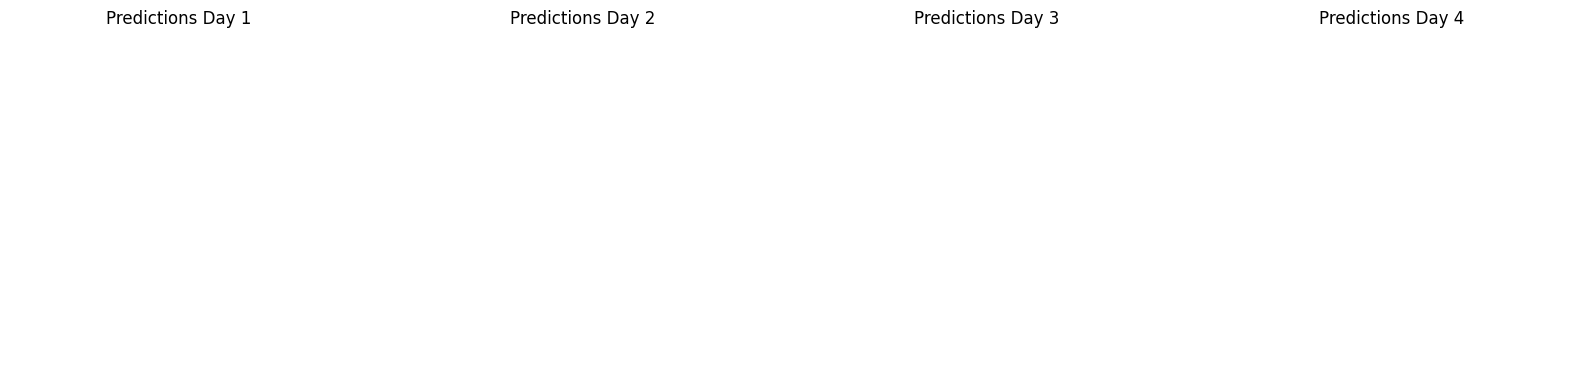

In [399]:
# Plot the 4 days of predictions
fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs = axs.ravel()

for i in range(0, 4):
    axs[i].imshow(predictions[0, i, :, :, 0], cmap="YlOrRd")
    axs[i].set_title("Predictions Day {}".format(i + 1))
    axs[i].axis("off")

plt.show()